# Stock Market Prediction

## Overview

Accurate prediction of stock market asset is a significant and challenging task due to complicated nature of the financial stock markets. Considering the increasing availability and affordability of powerful computational engines, deep learning methods of prediction have proved its efficiency in finance.

## Business Understanding

A time series regression model using NN or other advanced techniques is built to predict the stock market. Stock market prediction aims to determine the future movement of the stock value of a financial exchange. This project is helpful for Stock investors and investment banks to have a better understanding in developing economical Strategy and in making financial decisions.

## Data Understanding

Data Collection by API

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
import re
import pickle
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, auc, roc_curve
from sklearn.svm import SVC

from fbprophet import Prophet

import yfinance as yf

pd.options.display.max_columns = 200
sns.set_style('darkgrid')
#import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

### Yahoo Finance

In [11]:
tick = yf.Ticker("aapl")

# get stock info
#msft.info

# get historical market data
data = tick.history(period="max")

In [12]:
#df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).fillna(method='bfill')
data = data.reindex(pd.date_range(data.index[0], data.index[-1], freq='D')).interpolate()

In [13]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1980-12-12,0.100922,0.101361,0.100922,0.100922,4.690336e+08,0.0,0.0
1980-12-13,0.099313,0.099606,0.099167,0.099167,3.713173e+08,0.0,0.0
1980-12-14,0.097704,0.097851,0.097412,0.097412,2.736011e+08,0.0,0.0
1980-12-15,0.096096,0.096096,0.095657,0.095657,1.758848e+08,0.0,0.0
1980-12-16,0.089075,0.089075,0.088636,0.088636,1.057280e+08,0.0,0.0


### Web Scrapping

#### Web Scrapping by BeautifulSoup

In [8]:
# stock symbol
stock = 'AAPL'
# URL link 
url_is = 'https://finance.yahoo.com/quote/'+stock+'/financials?p='+stock
url_bs = 'https://finance.yahoo.com/quote/'+stock+'/balance-sheet?p='+stock
url_cf = 'https://finance.yahoo.com/quote/'+stock+'/cash-flow?p='+stock

In [9]:
page_is = requests.get(url_is)
#soup_is = BeautifulSoup(page_is.content, 'lxml')
soup_is = BeautifulSoup(page_is.content, 'html.parser')

In [11]:
features = soup_is.find_all('div', class_='D(tbr)')

In [12]:
headers = []
temp_list = []
label_list = []
final = []
index = 0
#create headers
for item in features[0].find_all('div', class_='D(ib)'):
    headers.append(item.text)
#statement contents
while index <= len(features)-1:
    #filter for each line of the statement
    temp = features[index].find_all('div', class_='D(tbc)')
    for line in temp:
        #each item adding to a temporary list
        temp_list.append(line.text)
    #temp_list added to final list
    final.append(temp_list)
    #clear temp_list
    temp_list = []
    index+=1
df = pd.DataFrame(final[1:])
df.columns = headers

In [13]:
#function to make all values numerical
def convert_to_numeric(column):
    first_col = [i.replace(',','') for i in column]
    second_col = [i.replace('-','') for i in first_col]
    final_col = pd.to_numeric(second_col)
    
    return final_col

In [14]:
for column in headers[1:]:    
    df[column] = convert_to_numeric(df[column])
    
final_df = df.fillna('-')

In [15]:
final_df.head()

,Breakdown,ttm,9/30/2020,9/30/2019,9/30/2018,9/30/2017
0,Total Revenue,2.73857e+08,2.74515e+08,2.60174e+08,2.65595e+08,2.29234e+08
1,Cost of Revenue,1.69277e+08,1.69559e+08,1.61782e+08,1.63756e+08,1.41048e+08
2,Gross Profit,1.0458e+08,1.04956e+08,9.8392e+07,1.01839e+08,8.8186e+07
3,Operating Expense,3.7442e+07,3.8668e+07,3.4462e+07,3.0941e+07,2.6842e+07
4,Operating Income,6.7138e+07,6.6288e+07,6.393e+07,7.0898e+07,6.1344e+07


#### Web Scrapping from JSON File

In [17]:
pattern  = re.compile(r'\s--\sData\s--\s')
scrpt_data = soup_is.find('script', text=pattern).contents[0]
start = scrpt_data.find('context')-2
json_data = json.loads(scrpt_data[start:-12])
json_data['context']['dispatcher']['stores']['QuoteSummaryStore'].keys()

dict_keys(['financialsTemplate', 'cashflowStatementHistory', 'balanceSheetHistoryQuarterly', 'earnings', 'price', 'incomeStatementHistoryQuarterly', 'incomeStatementHistory', 'balanceSheetHistory', 'cashflowStatementHistoryQuarterly', 'quoteType', 'summaryDetail', 'symbol', 'pageViews'])

In [18]:
quarterly_is = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['incomeStatementHistoryQuarterly']['incomeStatementHistory']

In [19]:
pd.json_normalize(quarterly_is).T.head()

,0,1,2,3
maxAge,1,1,1,1
researchDevelopment.raw,5163000000,4978000000,4758000000,4565000000
researchDevelopment.fmt,5.16B,4.98B,4.76B,4.57B
researchDevelopment.longFmt,"5,163,000,000","4,978,000,000","4,758,000,000","4,565,000,000"
incomeBeforeTax.raw,33579000000,14901000000,13137000000,13135000000


In [23]:
def _json(report):
    res = []
    for d in report:
        s = {}
        for k, v in d.items():
            try:
                s[k] = v['raw']
            except TypeError:
                continue
            except KeyError:
                continue
        res.append(s)
    return res

In [24]:
pd.DataFrame(_json(_is)).T.head()

,0,1,2,3
totalLiab,258549000000,248028000000,258578000000,241272000000
totalStockholderEquity,65339000000,90488000000,107147000000,134047000000
otherCurrentLiab,47867000000,43242000000,39293000000,38099000000
totalAssets,323888000000,338516000000,365725000000,375319000000
endDate,1601078400,1569628800,1538179200,1506729600


In [74]:
df_f = pd.read_csv('data/AAPL_quarterly_financials.csv', index_col=0, header=None).T
df_bs = pd.read_csv('data/AAPL_quarterly_balance-sheet.csv', index_col=0, header=None).T
df_cf = pd.read_csv('data/AAPL_quarterly_financials.csv', index_col=0, header=None).T

In [75]:
df = pd.concat([df_f, df_bs, df_cf], axis=1)

In [76]:
#df.drop_duplicates(inplace=True)
#df.drop(columns='ttm', inplace=True)
#df = df.dropna(subset=['12/31/2020'])

df = df.loc[:, ~df.columns.duplicated()]
df.drop(1, inplace=True)
df.dropna(subset=[2], axis=1, inplace=True)

In [77]:
df.columns = [re.sub(r'((?<=[^\W[A-Z])[A-Z]|(?<=\S)[A-Z](?=[a-z]))', r' \1', col.strip()) for col in df.columns]

In [78]:
df['name'] = pd.to_datetime(df['name'])
df.set_index('name', inplace=True)

In [79]:
for col in df.columns:
    df[col] = df[col].str.replace(',', '').astype(float)
    df[col].fillna(df[col].mean(), inplace=True)

In [80]:
df = df[::-1]

<AxesSubplot:>

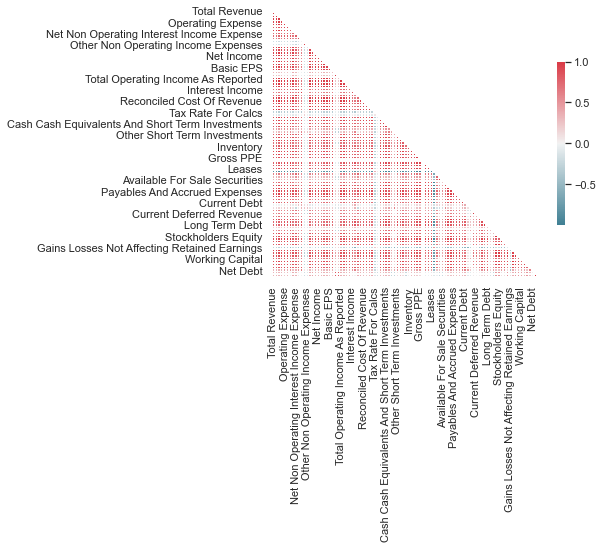

In [9]:
sns.set(style="white")

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.savefig('images/heatmap.jpeg', format='jpeg')

In [97]:
dfn = df.reindex(pd.date_range(data.index[0], data.index[-1], freq='D'))
dfn.fillna(method='bfill', inplace=True)
dfn.fillna(method='ffill', inplace=True)

### Trade Strategy
local minimum to buy, local maximum to sell, other time to hold.

In [ ]:
# FFT
# z = np.fft.fft(df.Close)
# Z = np.fft.fftshift(z)
# plt.plot(Z)
# plt.show()
# z = [0 if s>=-400 and s<=400 else s for s in z]
# #z[40:1300]=0
# l=np.fft.ifft(z)
# plt.plot(np.real(l))

In [55]:
data['decision'] = 'hold'

In [56]:
for i in range(1, len(data)-1):
    if data.Close[i-1] > data.Close[i] < data.Close[i+1]: data['decision'][i] = 'buy'
    elif data.Close[i-1] < data.Close[i] > data.Close[i+1]: data['decision'][i] = 'sell'

Text(0, 0.5, 'Count')

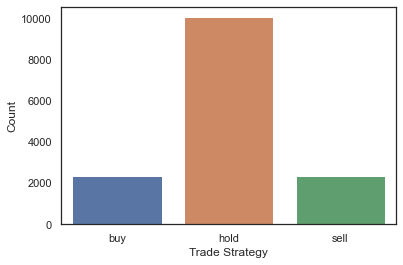

In [18]:
sns.barplot(x=['buy','hold','sell'], y=data.groupby('decision').size())
plt.xlabel('Trade Strategy')
plt.ylabel('Count')
#plt.savefig('images/trade.jpeg', format='jpeg')

### SMOTE and ADASYN
imbalance data problem

In [114]:
# X = df[:]
# y = data.loc[df.index].decision

X = dfn[:]
y = data.decision

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [115]:
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

In [ ]:
# adasyn = ADASYN()
# X_train, y_train = adasyn.fit_sample(X_train, y_train)

### PCA

In [116]:
pca = PCA(n_components=.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Text(0, 0.5, 'proportion of explained variance')

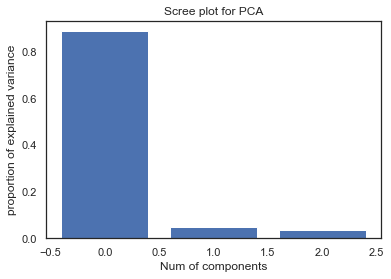

In [117]:
index = np.arange(3)
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')
#plt.savefig('images/pca.jpeg', format='jpeg')

### SVM

In [33]:
from sklearn.metrics import plot_confusion_matrix

In [118]:
pipe = Pipeline([('ss', StandardScaler()), ('svm', SVC())])
                 
param_grid = {'svm__kernel': ['linear', 'polynomial', 'rbf','sigmoid'],
              'svm__C': [0.0001, 0.01, 0.1, 1]}

grid_svm = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)
grid_svm.fit(X_train, y_train)

train_pred_svm = grid_svm.predict(X_train)
test_pred_svm = grid_svm.predict(X_test)

In [119]:
# metric evaluation
train_accu_svm = accuracy_score(y_train, train_pred_svm)
test_accu_svm = accuracy_score(y_test, test_pred_svm)
print('Training accuracy score: {}'.format(train_accu_svm))
print('Test accuracy score: {}'.format(test_accu_svm))

train_f1_svm = f1_score(y_train, train_pred_svm, average='micro')
test_f1_svm = f1_score(y_test, test_pred_svm, average='micro')
print('Training F1 score: {}'.format(train_f1_svm))
print('Test F1 score: {}'.format(test_f1_svm))

print(classification_report(y_test, test_pred_svm))

Training accuracy score: 0.3646825887885163
Test accuracy score: 0.45759837177747625
Training F1 score: 0.3646825887885163
Test F1 score: 0.45759837177747625
              precision    recall  f1-score   support

         buy       0.17      0.24      0.20       488
        hold       0.70      0.57      0.63      1971
        sell       0.18      0.24      0.20       489

    accuracy                           0.46      2948
   macro avg       0.35      0.35      0.34      2948
weighted avg       0.52      0.46      0.48      2948



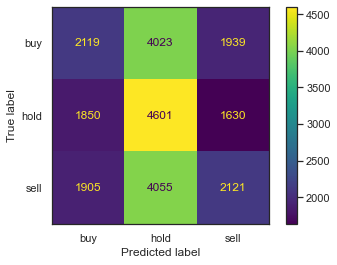

In [120]:
plot_confusion_matrix(grid_svm, X_train, y_train)

### RandomForest

In [122]:
from sklearn.ensemble import RandomForestClassifier

In [123]:
pipe = Pipeline([('ss', StandardScaler()), ('rf', RandomForestClassifier())])

param_grid = {'rf__n_estimators': [20],
              'rf__criterion': ['gini', "entropy"],    
              'rf__max_depth': [4, 6, 8],
              'rf__max_features': [3, 4, 7],
              'rf__min_samples_split': [2, 5, 10],
              'rf__min_samples_leaf': [1, 3, 6]}

grid_rf = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)
grid_rf.fit(X_train, y_train)

train_pred_rf = grid_rf.predict(X_train)
test_pred_rf = grid_rf.predict(X_test)

In [124]:
# metric evaluation
train_accu_rf = accuracy_score(y_train, train_pred_rf)
test_accu_rf = accuracy_score(y_test, test_pred_rf)
print('Training accuracy score: {}'.format(train_accu_rf))
print('Test accuracy score: {}'.format(test_accu_rf))

train_f1_rf = f1_score(y_train, train_pred_rf, average='micro')
test_f1_rf = f1_score(y_test, test_pred_rf, average='micro')
print('Training F1 score: {}'.format(train_f1_rf))
print('Test F1 score: {}'.format(test_f1_rf))

print(classification_report(y_test, test_pred_rf))

Training accuracy score: 0.39112321082374296
Test accuracy score: 0.3619402985074627
Training F1 score: 0.39112321082374296
Test F1 score: 0.3619402985074627
              precision    recall  f1-score   support

         buy       0.15      0.26      0.19       488
        hold       0.68      0.41      0.52      1971
        sell       0.14      0.25      0.18       489

    accuracy                           0.36      2948
   macro avg       0.32      0.31      0.29      2948
weighted avg       0.51      0.36      0.41      2948



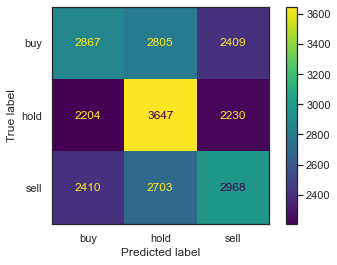

In [130]:
plot_confusion_matrix(grid_rf, X_train, y_train)

### XGBoost

In [126]:
from xgboost import XGBClassifier

In [127]:
pipe = Pipeline([('ss', StandardScaler()), ('xgb', XGBClassifier())])

param_grid = {
              'xgb__n_estimators': [10],
              'xgb__criterion': ['gini', "entropy"],    
              'xgb__max_depth': [4, 6, 8],
              'xgb__max_features': [3, 4, 7],
              'xgb__min_samples_split': [2, 5, 10],
              'xgb__min_samples_leaf': [1, 3, 6],              
#               'xgb__learning_rate': [0.2],
#               'xgb__min_child_weight': [1, 2],
#               'xgb__subsample': [0.5]
             }

grid_xgb = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

train_pred_xgb = grid_xgb.predict(X_train)
test_pred_xgb = grid_xgb.predict(X_test)

[19:50:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { criterion, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [128]:
# metric evaluation
train_accu_xgb = accuracy_score(y_train, train_pred_xgb)
test_accu_xgb = accuracy_score(y_test, test_pred_xgb)
print('Training accuracy score: {}'.format(train_accu_xgb))
print('Test accuracy score: {}'.format(test_accu_xgb))

train_f1_xgb = f1_score(y_train, train_pred_xgb, average='micro')
test_f1_xgb = f1_score(y_test, test_pred_xgb, average='micro')
print('Training F1 score: {}'.format(train_f1_xgb))
print('Test F1 score: {}'.format(test_f1_xgb))

print(classification_report(y_test, test_pred_xgb))

Training accuracy score: 0.39487687167429775
Test accuracy score: 0.3483717774762551
Training F1 score: 0.39487687167429775
Test F1 score: 0.3483717774762551
              precision    recall  f1-score   support

         buy       0.14      0.24      0.17       488
        hold       0.68      0.40      0.50      1971
        sell       0.14      0.26      0.18       489

    accuracy                           0.35      2948
   macro avg       0.32      0.30      0.28      2948
weighted avg       0.50      0.35      0.39      2948



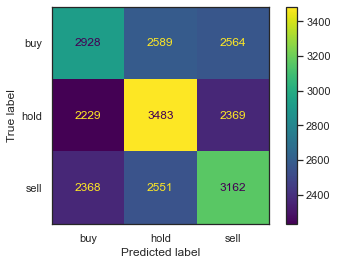

In [132]:
plot_confusion_matrix(grid_xgb, X_train, y_train)
#plt.savefig('images/xgb.jpeg', format='jpeg')